<a href="https://colab.research.google.com/github/hoogencj/CS5262-Final-Project/blob/main/Preproc_psp_for_collab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [97]:
! apt-get install -y libsm6 libxext6 libxrender-dev
! pip install opencv-python
! pip install --upgrade git+https://github.com/divamgupta/image-segmentation-keras
! pip install segmentation-models

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libsm6 is already the newest version (2:1.2.2-1).
libxext6 is already the newest version (2:1.3.3-1).
libxrender-dev is already the newest version (1:0.9.10-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
  Cloning https://github.com/divamgupta/image-segmentation-keras to /tmp/pip-req-build-nx5_ngfj
  Running command git clone -q https://github.com/divamgupta/image-segmentation-keras /tmp/pip-req-build-nx5_ngfj


In [98]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [99]:
#The imports we will all need
from matplotlib import pyplot as plt 
from PIL import Image, ImageOps
import os
import numpy as np
from sklearn.metrics import roc_curve, auc, f1_score
import glob
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
import cv2
import segmentation_models as sm
sm.set_framework('tf.keras')


#You may have to remove this import and all the @njit wrappers at the top of each function
#I don't think numba works with collab is why
#If it does, keep it. The preproccessing code will run faster if the wrappers are present
#The preprocessing code will take a bit to run without it... I brute forced everything :/
from numba import njit

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [100]:
#The original size of the images, leave as is
OG_SIZE = (1000, 1000)

#The size of image that will be put into the NN
NEW_SIZE = (1008, 1008)

#Resizing flag. If true resizing will be used to make input of size NEW_SIZE
#If false, padding is added on the left and bottom sides of image to make input of size NEW_SIZE
#if using padding, you can only increase dims of OG_SIZE.
RESIZE = True

#The interpolation method for when you want to resize (.tiff and np.arrays will only work with INTER_NEAREST)
interp = cv2.INTER_NEAREST

#How many times to split up the image for the NN
#Only need to use this if having memory troubles
#Will turn 1 (1024,1024) image into 4 (512,512) images for DIV = 2 (or 16 (256,256) for DIV=4 and so on)
DIV = 1


#Scales all input images between 0 and 1
def Scale(arr):
    arr = (arr-np.min(arr))/(np.max(arr)-np.min(arr))
    return arr


#Reserve the space for all inputs and outputs
train_imgs = np.zeros((26,NEW_SIZE[0],NEW_SIZE[1]))
valid_imgs = np.zeros((6,NEW_SIZE[0],NEW_SIZE[1]))
test_imgs = np.zeros((7,NEW_SIZE[0],NEW_SIZE[1]))

train_masks = np.zeros((26,NEW_SIZE[0],NEW_SIZE[1]))
valid_masks = np.zeros((6,NEW_SIZE[0],NEW_SIZE[1]))
test_masks = np.zeros((7,NEW_SIZE[0],NEW_SIZE[1]))

tr = 0
va = 0
te = 0

path = '/content/drive/MyDrive/CS_5262_Final_Project_PSPNet/'

#Goes into Images folder in same folder as this .ipynb and extracts neccesary data
#Make sure you have this folder downloaded the same way as the GitHub 'Images' folder I posted
for folder in os.listdir(path):
    for image in sorted(glob.glob(path + folder + '/*.tif')):
        identifier = image[len(image)-8:len(image)-4]
            
        img = Image.open(image)
            
        if folder == 'data_trainset':
            if identifier == 'mask':
                if RESIZE:
                    train_masks[tr,0:NEW_SIZE[0],0:NEW_SIZE[1]] = cv2.resize(np.asarray(img)/255, NEW_SIZE, interpolation = interp)
                    tr += 1
                else:
                    train_masks[tr,0:OG_SIZE[0],0:OG_SIZE[1]] = np.asarray(img)/255
                    tr += 1
            else:
                if RESIZE:
                    train_imgs[tr,0:NEW_SIZE[0],0:NEW_SIZE[1]] = cv2.resize(Scale(np.asarray(img)), NEW_SIZE, interpolation = interp)
                else:
                    train_imgs[tr,0:OG_SIZE[0],0:OG_SIZE[1]] = Scale(np.asarray(img))
                    
                    
        elif folder == 'data_validset':
            if identifier == 'mask':
                if RESIZE:
                    valid_masks[va,0:NEW_SIZE[0],0:NEW_SIZE[1]] = cv2.resize(np.asarray(img)/255, NEW_SIZE, interpolation = interp)
                    va += 1
                else:
                    valid_masks[va,0:OG_SIZE[0],0:OG_SIZE[1]] = np.asarray(img)/255
                    va += 1
            else:
                if RESIZE:
                    valid_imgs[va,0:NEW_SIZE[0],0:NEW_SIZE[1]] = cv2.resize(Scale(np.asarray(img)), NEW_SIZE, interpolation = interp)
                else:
                    valid_imgs[va,0:OG_SIZE[0],0:OG_SIZE[1]] = Scale(np.asarray(img))
                
                
        elif folder == 'data_testset':
            if identifier == 'mask':
                if RESIZE:
                    test_masks[te,0:NEW_SIZE[0],0:NEW_SIZE[1]] = cv2.resize(np.asarray(img)/255, NEW_SIZE, interpolation = interp)
                    te += 1
                else:
                    test_masks[te,0:OG_SIZE[0],0:OG_SIZE[1]] = np.asarray(img)/255
                    te += 1
            else:
                if RESIZE:
                    test_imgs[te,0:NEW_SIZE[0],0:NEW_SIZE[1]] = cv2.resize(Scale(np.asarray(img)), NEW_SIZE, interpolation = interp)
                else:
                    test_imgs[te,0:OG_SIZE[0],0:OG_SIZE[1]] = Scale(np.asarray(img))

In [101]:
#Only really needed if memory problems,
#Keep in code tho
#If DIV is set to 1 it will work how you guys need it
@njit
def ReshapeX(arr, div):
    out = np.zeros((int((div**2)*arr.shape[0]), int(arr.shape[1]/div), int(arr.shape[2]/div)))
    oc = 0
    for img in arr:
        for d1 in range(div):
            for d2 in range(div):
                out[oc,:,:] = img[d1*int(arr.shape[1]/div):(d1+1)*int(arr.shape[1]/div), d2*int(arr.shape[2]/div):(d2+1)*int(arr.shape[2]/div)]
                oc += 1
    return out

X_train = ReshapeX(train_imgs, DIV)
X_valid = ReshapeX(valid_imgs, DIV)
X_test = ReshapeX(test_imgs, DIV)


#Adds an extra dimension, neccesary for keras formatting
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
X_valid = X_valid.reshape(X_valid.shape[0],X_valid.shape[1],X_valid.shape[2],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)

#puts Y data into 1 hot encoded formatting for keras
@njit
def OHE(arr, div):
    out = np.zeros((int((div**2)*arr.shape[0]), int(arr.shape[1]/div), int(arr.shape[2]/div), 2, 1))
    
    oc = 0
    for img in arr:
        for d1 in range(div):
            for d2 in range(div):
                pc = 0
                ic = 0
                for i in range(d1*int(arr.shape[1]/div),(d1+1)*int(arr.shape[1]/div)):
                    jc = 0
                    for j in range(d2*int(arr.shape[2]/div),(d2+1)*int(arr.shape[2]/div)):
                        value = img[i,j]
                        if int(value) == 0:
                            out[oc,ic,jc,:] = np.array([[1], [0]]) #No fracture
                        if int(value) == 1:
                            out[oc,ic,jc,:] = np.array([[0], [1]]) #Fracture
                        pc += 1
                        jc += 1
                    ic += 1
                oc += 1
    return out

Y_train = OHE(train_masks,DIV)
Y_valid = OHE(valid_masks,DIV)
Y_test = OHE(test_masks,DIV)


#Adds weight to samples for loss funtion
#since there are so few fracture pixels compared to no fracture
#it helps to add additional weight in our loss function to the fracture class
#Right now fractures are weighted 3x as much as no fracture
#If you don't wanna use it, dont pass it through your fit funtion
@njit
def SampleWeight(arr, weight):
    ws = np.ones((arr.shape[0],arr.shape[1],arr.shape[2]))
    for b, block in enumerate(arr):
        for i, ival in enumerate(block):
            for j, jval in enumerate(ival):
                if jval[0,0] == 0:
                    ws[b,i,j] = weight #Change this number to set the fracture weight
    return ws

sample_weight_train = SampleWeight(Y_train, weight=4)
sample_weight_valid = SampleWeight(Y_valid, weight=4)

In [102]:
#Instantiate the model, compile the model, and train the model
#several parameters of this step will need customization depending of the model

input_shape = (int(NEW_SIZE[0]/DIV), int(NEW_SIZE[1]/DIV), 1)
classes = 2
activation='softmax'
epochs = 1000
downsample_factor = 4
BACKBONE = 'resnet50'
batch_size = 2
lr = 1e-3

checkpoint_path = '/content/drive/MyDrive/CS_5262_Final_Project_PSPNet/psp_best_model.hdf5'

preprocess_input = sm.get_preprocessing(BACKBONE)

X_train = preprocess_input(X_train)
Y_train = preprocess_input(Y_train)

metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.AUC(), sm.metrics.FScore()]
loss = sm.losses.binary_crossentropy
optimizer = keras.optimizers.Adam(lr)
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_f1-score', verbose=0, save_best_only=True, save_weights_only=True, mode='auto', save_freq='epoch')

model = sm.PSPNet(backbone_name=BACKBONE, 
                  input_shape=input_shape, 
                  classes=classes, 
                  activation=activation, 
                  downsample_factor=downsample_factor, 
                  encoder_weights=None)
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [103]:
history = model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid, sample_weight_valid), epochs=epochs, verbose=1, batch_size=batch_size, sample_weight=sample_weight_train, callbacks=[earlystop, checkpoint])

Epoch 1/1000
13/13 [==============================] - 21s 1s/step - loss: 0.1504 - binary_accuracy: 0.9740 - auc_6: 0.9927 - f1-score: 0.4913 - val_loss: 0.1266 - val_binary_accuracy: 0.9946 - val_auc_6: 0.9946 - val_f1-score: 0.4985
Epoch 2/1000
13/13 [==============================] - 18s 1s/step - loss: 0.0365 - binary_accuracy: 0.9936 - auc_6: 0.9954 - f1-score: 0.5068 - val_loss: 0.0839 - val_binary_accuracy: 0.9904 - val_auc_6: 0.9965 - val_f1-score: 0.5065
Epoch 3/1000
13/13 [==============================] - 18s 1s/step - loss: 0.0278 - binary_accuracy: 0.9935 - auc_6: 0.9970 - f1-score: 0.5178 - val_loss: 0.1177 - val_binary_accuracy: 0.9911 - val_auc_6: 0.9988 - val_f1-score: 0.5124
Epoch 4/1000
13/13 [==============================] - 18s 1s/step - loss: 0.0228 - binary_accuracy: 0.9936 - auc_6: 0.9974 - f1-score: 0.5289 - val_loss: 0.0786 - val_binary_accuracy: 0.9944 - val_auc_6: 0.9988 - val_f1-score: 0.5175
Epoch 5/1000
13/13 [==============================] - 18s 1s/ste

In [104]:
#Undo reshape I used for memory and take argmax of results (Just takes argmax if DIV = 1)
#arg_arg true or false if you want argmax or not, respectively
def preds2imgs(arr, div, arg_arg):
    if arg_arg:
        temp = np.argmax(arr, axis=3)
        out = np.zeros((int((arr.shape[0])/(div**2)),int((arr.shape[1]*div)),int(arr.shape[1]*div)))
    else:
        temp = arr
        out = np.zeros((int((arr.shape[0])/(div**2)),int((arr.shape[1]*div)),int(arr.shape[1]*div),2))
        
    tc = 0
    for img in range(int((arr.shape[0])/(div**2))):
        for d1 in range(div):
            for d2 in range(div):
                if arg_arg:
                    out[img, d1*int(temp.shape[1]):(d1+1)*int(temp.shape[1]), d2*int(temp.shape[1]):(d2+1)*int(temp.shape[1])] = temp[tc]
                    tc += 1
                else:
                    out[img, d1*int(temp.shape[1]):(d1+1)*int(temp.shape[1]), d2*int(temp.shape[1]):(d2+1)*int(temp.shape[1]),:] = temp[tc]
                    tc += 1
    return out


#Show loss and accuracy of all datasets from epoch of restored weights
acc_train = model.evaluate(X_train, Y_train, verbose=0, batch_size=1)
print(" Train loss: ", acc_train[0], " Train accuracy: ", acc_train[1])
acc_valid = model.evaluate(X_valid, Y_valid, verbose=0, batch_size=1)
print(" Valid loss: ", acc_valid[0], " Valid accuracy: ", acc_valid[1])
acc_test = model.evaluate(X_test, Y_test, verbose=0, batch_size=1)
print(" Test loss: ", acc_test[0], " Test accuracy: ", acc_test[1])

#predict your results
valid_results = model.predict(X_valid, batch_size=1)
test_results = model.predict(X_test, batch_size=1)

valid_argmax_pred = preds2imgs(valid_results, DIV, True)
valid_argmax_true = preds2imgs(np.squeeze(Y_valid, axis = 4), DIV, True)

test_argmax_pred = preds2imgs(test_results, DIV, True)
test_argmax_true = preds2imgs(np.squeeze(Y_test, axis = 4), DIV, True)

# #Plot accuracies from training
# plt.plot(history.history['categorical_accuracy'])
# plt.plot(history.history['val_categorical_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()

# #Plot losses from training
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()


#Resizes or removes padding from argmax results depending on which you used.
def ToOGSize(arr, num_images, RESIZE, OG_SIZE, interp):
    OG = np.zeros((num_images,OG_SIZE[0],OG_SIZE[1]))
    for i in range(num_images):
        if RESIZE:
            OG[i,:,:] = cv2.resize(arr[i], OG_SIZE, interpolation=interp)
        else:
            OG[i,:,:] = arr[i,0:OG_SIZE[0],0:OG_SIZE[1]]
    return OG

valid_argmax_pred_OG = ToOGSize(valid_argmax_pred,
                                6, RESIZE,
                                OG_SIZE, interp)
valid_argmax_true_OG = ToOGSize(valid_argmax_true,
                                6, RESIZE,
                                OG_SIZE, interp)

test_argmax_pred_OG = ToOGSize(test_argmax_pred,
                               7, RESIZE,
                               OG_SIZE, interp)

test_argmax_true_OG = ToOGSize(test_argmax_true,
                               7, RESIZE,
                               OG_SIZE, interp)

 Train loss:  0.023703794926404953  Train accuracy:  0.9938347339630127
 Valid loss:  0.015278056263923645  Valid accuracy:  0.9951164722442627
 Test loss:  0.04179832711815834  Test accuracy:  0.9888876676559448


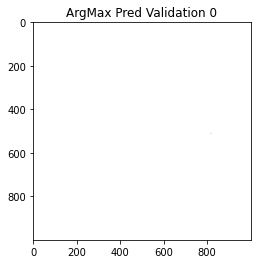

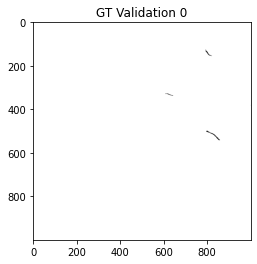

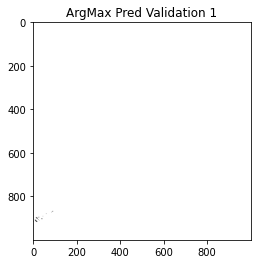

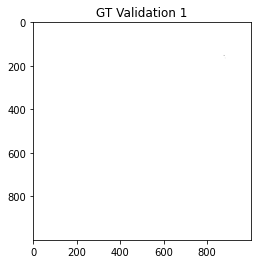

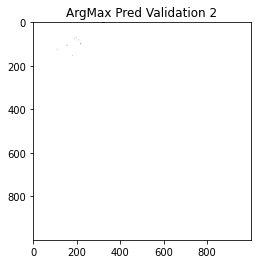

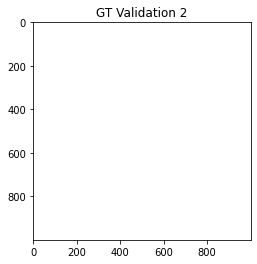

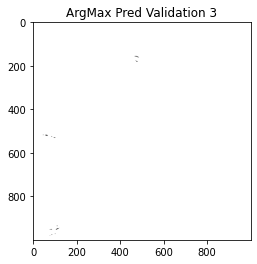

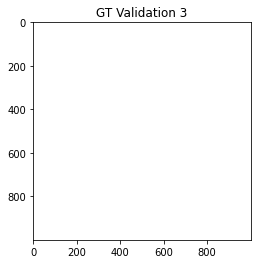

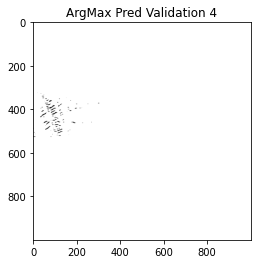

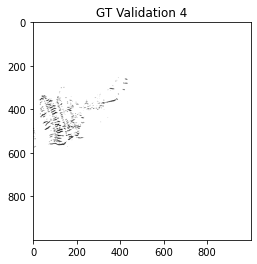

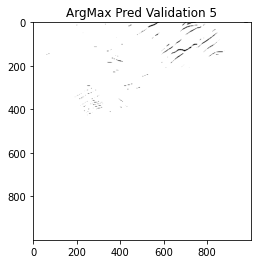

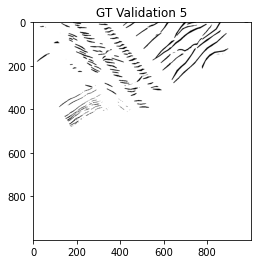

In [105]:
#Plot argmax results for validation data and GT
for i, pred in enumerate(valid_argmax_pred_OG):
    plt.imshow(pred,cmap='binary')
    plt.title("ArgMax Pred Validation "+ str(i))
    plt.show()
    plt.imshow(valid_argmax_true_OG[i], cmap='binary')
    plt.title("GT Validation "+ str(i))
    plt.show()

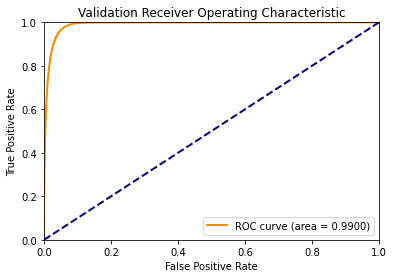

AUC =  0.9899785770385233


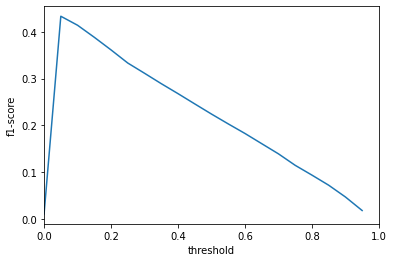

In [106]:
#Formats the data as neccesary to use sklearn roc_curve function
def ToROC(arr, arr_pred):
    out = np.zeros(int(arr.shape[0]*arr.shape[1]*arr.shape[2]))
    out_pred = np.zeros(int(arr.shape[0]*arr.shape[1]*arr.shape[2]))
    c = 0
    for b, block in enumerate(arr):
        for i, ival in enumerate(block):
            for j, jval in enumerate(ival):
                if jval[1] == 1:
                    out[c] = 1
                
                out_pred[c] = arr_pred[b,i,j,1]
                c += 1
    return out, out_pred

temp_Y_valid_OG = Y_valid.reshape(6,NEW_SIZE[0],NEW_SIZE[0],2,1)
Y_valid_OG = np.zeros((7,OG_SIZE[0],OG_SIZE[0],2,1))

temp_valid_results_OG = valid_results.reshape(6,NEW_SIZE[0],NEW_SIZE[0],2)
valid_results_OG = np.zeros((7,OG_SIZE[0],OG_SIZE[0],2,1))

if RESIZE:
    for i in range(6):
        temp_OG_0 = cv2.resize(temp_Y_valid_OG[i,:,:,0,0], OG_SIZE, interpolation=interp)
        temp_OG_1 = cv2.resize(temp_Y_valid_OG[i,:,:,1,0], OG_SIZE, interpolation=interp)
        Y_valid_OG[i,:,:,0,0] = temp_OG_0
        Y_valid_OG[i,:,:,1,0] = temp_OG_1
        
        temp_OG_0 = cv2.resize(temp_valid_results_OG[i,:,:,0], OG_SIZE, interpolation=interp)
        temp_OG_1 = cv2.resize(temp_valid_results_OG[i,:,:,1], OG_SIZE, interpolation=interp)
        
        valid_results_OG[i,:,:,0] = np.expand_dims(temp_OG_0, axis = 2)
        valid_results_OG[i,:,:,1] = np.expand_dims(temp_OG_1, axis = 2)
else:
    Y_valid_OG = temp_Y_valid_OG[:,0:OG_SIZE[0],0:OG_SIZE[1],:,:]
    valid_results_OG = temp_valid_results_OG[:,0:OG_SIZE[0],0:OG_SIZE[1],:]

#Generates the ROC curve and solves the AUC
valid_roc_true, valid_roc_pred = ToROC(np.squeeze(Y_valid_OG, axis=4), valid_results_OG)
fpr, tpr, thresholds = roc_curve(valid_roc_true, valid_roc_pred, pos_label=1)
roc_auc = auc(fpr, tpr)

#Plot ROC curve and print AUC score
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label = 'ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw=lw, linestyle = '--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.show()
print('AUC = ',roc_auc)


#Determine the fracture threshold best suitable for maximizing f1-score based on validation data
f1 = []
spacing = 0.05
thr = np.arange(0,1,spacing)
for i in thr:
    f1.append(f1_score(valid_roc_true, (valid_roc_pred > i)))

#saves value of best threshold
threshold = np.argmax(f1)*spacing

#Plots the f1-score as a function of threshold values
plt.figure()
plt.plot(thr, f1)
plt.xlim([0,1])
plt.xlabel('threshold')
plt.ylabel('f1-score')
plt.show()

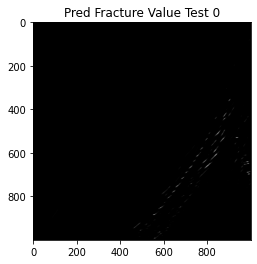

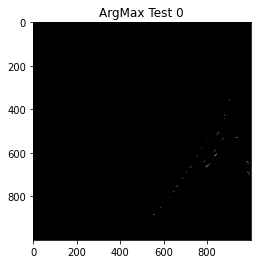

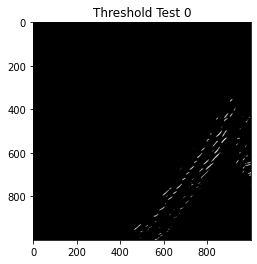

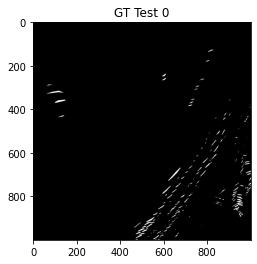

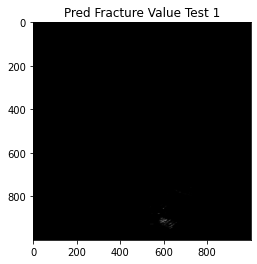

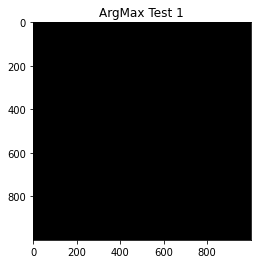

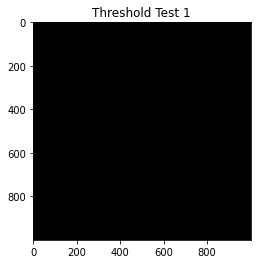

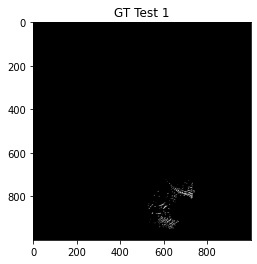

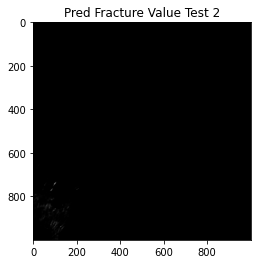

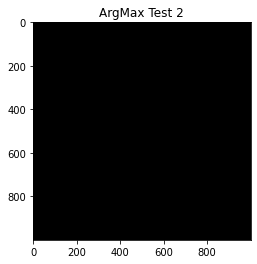

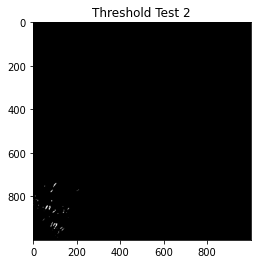

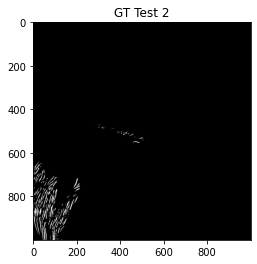

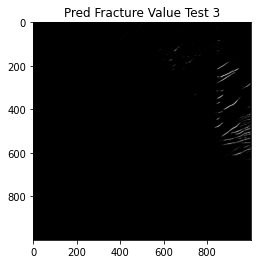

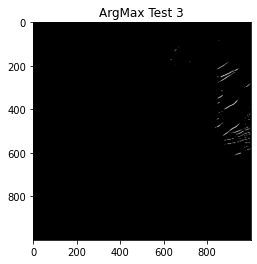

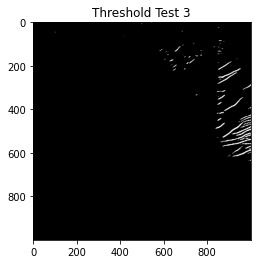

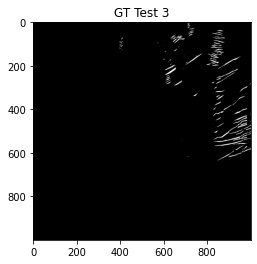

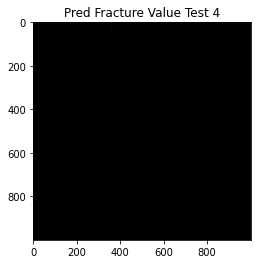

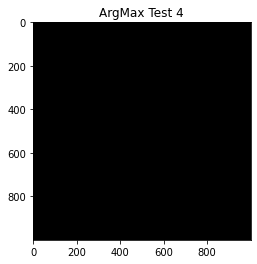

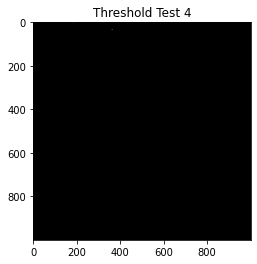

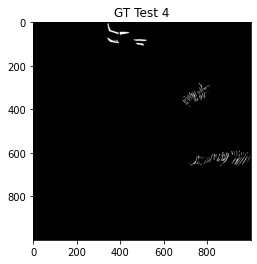

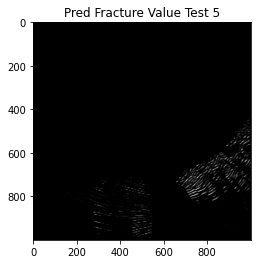

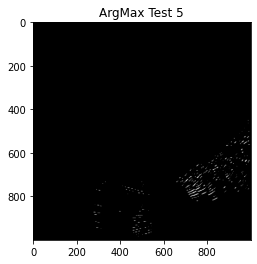

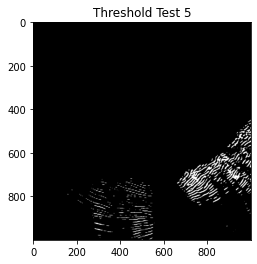

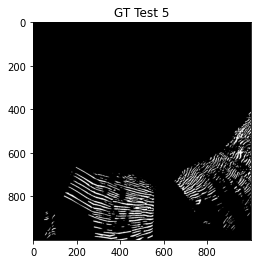

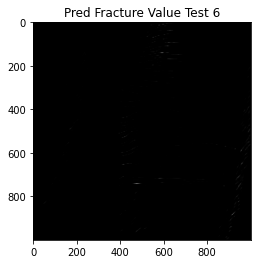

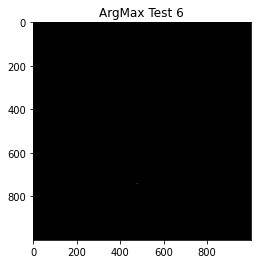

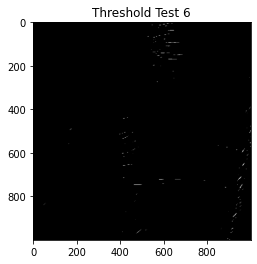

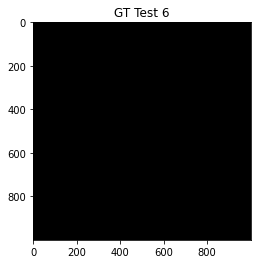

Threshold Test F1-score =  0.3893501145684588


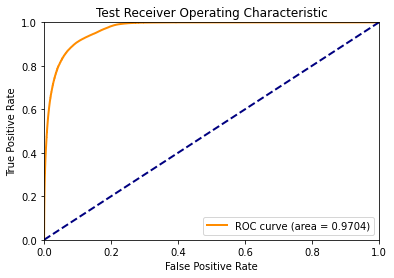

Raw Preds Test AUC =  0.9703690348351225


In [107]:
#Applies threshold found previously to test results

def ApplyThreshold(arr, thr):
    out = np.zeros((arr.shape[0],arr.shape[1],arr.shape[2]))
    for b, block in enumerate(arr):
        for i, ival in enumerate(block):
            for j, jval in enumerate(ival):
                if jval[1] >= thr:
                    out[b,i,j] = 1
    return out

test_pred_thr = ApplyThreshold(preds2imgs(test_results, DIV, False), threshold)

#Reshapes raw test probability results as neccesary for plotting.
temp_Y_test_OG = Y_test.reshape(7,NEW_SIZE[0],NEW_SIZE[0],2,1)
Y_test_OG = np.zeros((7,OG_SIZE[0],OG_SIZE[0],2,1))

temp_test_results_OG = test_results.reshape(7,NEW_SIZE[0],NEW_SIZE[0],2)
test_results_OG = np.zeros((7,OG_SIZE[0],OG_SIZE[0],2,1))

if RESIZE:
    for i in range(7):
        temp_OG_0 = cv2.resize(temp_Y_test_OG[i,:,:,0,0], OG_SIZE, interpolation=interp)
        temp_OG_1 = cv2.resize(temp_Y_test_OG[i,:,:,1,0], OG_SIZE, interpolation=interp)
        Y_test_OG[i,:,:,0,0] = temp_OG_0
        Y_test_OG[i,:,:,1,0] = temp_OG_1
        
        temp_OG_0 = cv2.resize(temp_test_results_OG[i,:,:,0], OG_SIZE, interpolation=interp)
        temp_OG_1 = cv2.resize(temp_test_results_OG[i,:,:,1], OG_SIZE, interpolation=interp)
        
        test_results_OG[i,:,:,0] = np.expand_dims(temp_OG_0, axis = 2)
        test_results_OG[i,:,:,1] = np.expand_dims(temp_OG_1, axis = 2)
else:
    Y_test_OG = temp_Y_test_OG[:,0:OG_SIZE[0],0:OG_SIZE[1],:,:]
    test_results_OG = temp_test_results_OG[:,0:OG_SIZE[0],0:OG_SIZE[1],:]
        
#Plot the raw output of fractures, the ArgMax results, the Threshold applied results, and the Ground truths
for i in range(7):
    plt.imshow(test_results_OG[i,:,:,1].reshape((test_results_OG.shape[1], test_results_OG.shape[2])),cmap='binary_r') #Show if you use softmax activation
    plt.title("Pred Fracture Value Test "+ str(i))
    plt.show()
    plt.imshow(test_argmax_pred_OG[i],cmap='binary_r')
    plt.title("ArgMax Test "+ str(i))
    plt.show()
    plt.imshow(test_pred_thr[i,0:OG_SIZE[0],0:OG_SIZE[1]],cmap='binary_r')
    plt.title("Threshold Test "+ str(i))
    plt.show()
    plt.imshow(test_argmax_true_OG[i], cmap='binary_r')
    plt.title("GT Test "+ str(i))
    plt.show()


#Solve the ROC curve and AUC for test data
roc_true_Y, roc_pred_Y = ToROC(np.squeeze(Y_test_OG, axis=4), test_results_OG)
# fpr, tpr, thresholds = roc_curve(roc_true_Y, (roc_pred_Y > threshold), pos_label=1)
# roc_auc = auc(fpr, tpr)

# #Plot the ROC curve, print AUC, and print F1-score score for test data
# plt.figure()
# lw = 2
# plt.plot(fpr, tpr, color='darkorange', lw=lw, label = 'ROC curve (area = %0.4f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color = 'navy', lw=lw, linestyle = '--')
# plt.xlim([0,1])
# plt.ylim([0,1])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Test Receiver Operating Characteristic')
# plt.legend(loc = 'lower right')
# plt.show()
# print('Threshold Test AUC = ',roc_auc)
print('Threshold Test F1-score = ', f1_score(roc_true_Y, (roc_pred_Y > threshold)))


# fpr, tpr, thresholds = roc_curve(test_argmax_true_OG.flatten(), test_argmax_pred_OG.flatten(), pos_label=1)
# roc_auc = auc(fpr, tpr)
# plt.figure()
# lw = 2
# plt.plot(fpr, tpr, color='darkorange', lw=lw, label = 'ROC curve (area = %0.4f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color = 'navy', lw=lw, linestyle = '--')
# plt.xlim([0,1])
# plt.ylim([0,1])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Test Receiver Operating Characteristic')
# plt.legend(loc = 'lower right')
# plt.show()
# print('ArgMax Test AUC = ',roc_auc)
# print('ArgMax Test F1-score = ', f1_score(test_argmax_true_OG.flatten(), test_argmax_pred_OG.flatten()))


fpr, tpr, thresholds = roc_curve(Y_test_OG[:,:,:,1].flatten(), test_results_OG[:,:,:,1].flatten(), pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label = 'ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw=lw, linestyle = '--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.show()
print('Raw Preds Test AUC = ',roc_auc)

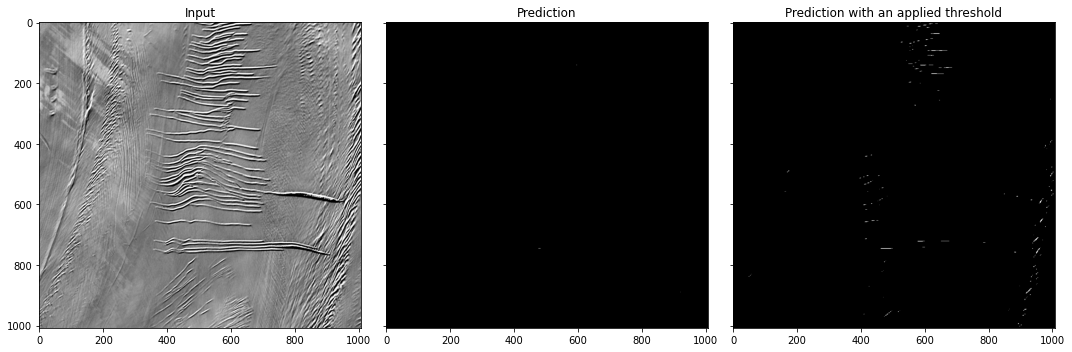

In [108]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15,5))

ax[0].imshow(test_imgs[6], aspect="auto", cmap='binary_r')

ax[1].imshow(test_argmax_pred[6], aspect="auto", cmap='binary_r')

ax[2].imshow(test_pred_thr[6], cmap='binary_r', aspect="auto")

ax[0].set_title("Input")
ax[1].set_title("Prediction")
ax[2].set_title("Prediction with an applied threshold")
fig.tight_layout()